In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from halp.undirected_hypergraph import UndirectedHypergraph
from halp.utilities import undirected_graph_transformations, undirected_matrices
import scipy

## E-R Hypergraph CEC vs $PG_{(\gamma)}$

Constructing hypergraphs via E-R model and comparing centrality measures. Note that we also started performing similar results on Preferential Attachment but did not put this in the report.



In [3]:
def hg_pagerank_full_eig_decomp(T, alpha):
    """
    
    Computes the pagerank for a Hypergraph H, for a random walk determined by transition matrix T.
    Computes by finding the left eigenvector associated to the eigenvalue \lambda = 1
    Does so by finding all eigenpairs of the matrix and then filtered
    (Takes long time for large matrices, see hg_pagerank_fast instead)
    
    """
    
    
    # p(t+1)_i = a * p(t)_i*T + (1-a)/n * 1
    
    nodes = list(range(len(T)))
    n = len(nodes)
    
    T = alpha*T + (1-alpha)/n*np.ones((n,n))
    
    # Find the right eigenvalue associated with the 1 eigenvalue (note the transpose of T)
    values, vectors = np.linalg.eig(T.T)
    vector = vectors[:,np.isclose(values, 1)] # find correct evector, code used from: 
    vector = vector[:,0]
    
    # normalise the stationary distribution
    stat_dist = vector / vector.sum()
    stat_dist = stat_dist.real
    
    
    #return the hypergraph PageRank
    return stat_dist

In [4]:
def power_iteration(A, num_simulations: int):

    # Code taken from "https://en.wikipedia.org/wiki/Power_iteration"
    b_k = np.random.rand(A.shape[1])

    for _ in range(num_simulations):
        # calculate the matrix-by-vector product Ab
        b_k1 = np.dot(A, b_k)

        # calculate the norm
        b_k1_norm = np.linalg.norm(b_k1, 1)

        # re normalize the vector
        b_k = b_k1 / b_k1_norm

    return b_k

def hg_pagerank_power(T, alpha, num_sims):
    nodes = list(range(len(T)))
    n = len(nodes)

    T = alpha*T + (1-alpha)/n*np.ones((n,n)) # PageRank w/ teleportation
    
    res_pgrk = power_iteration(T.T, 100) # power method
    
    return res_pgrk

### Example

In [5]:
# generate a random bi-partite graph using Erdos-Renyi model.

G = nx.bipartite.random_graph(10,7, 0.4)

C:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: 
The is_numlike function was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use isinstance(..., numbers.Number) instead.
  if cb.is_numlike(alpha):


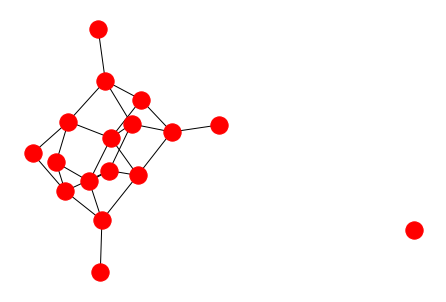

In [6]:
nx.draw(G)

In [322]:
I = nx.bipartite.biadjacency_matrix(G, row_order = range(10)).toarray() # incidence matrix
A = I @ I.T # hyperadjacency matrix
A

array([[4, 2, 2, 1, 2, 0, 0, 0, 2, 1],
       [2, 3, 3, 2, 0, 1, 0, 0, 1, 1],
       [2, 3, 4, 3, 1, 1, 0, 0, 2, 1],
       [1, 2, 3, 4, 2, 1, 1, 0, 3, 0],
       [2, 0, 1, 2, 4, 0, 1, 0, 3, 0],
       [0, 1, 1, 1, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [2, 1, 2, 3, 3, 0, 1, 0, 4, 0],
       [1, 1, 1, 0, 0, 0, 0, 0, 0, 1]], dtype=int32)

In [323]:
C = I.T @ I
C_hat = np.diag(np.diag(C))


# compute the asymptotic walk distributions

#         start_2 = time.time()
##################################################################################

# equal choice walker

gamma = -1


K_e = np.zeros((len(A), len(A)))
C_alt = np.diag(np.diag((C_hat - 1).astype(float)**gamma)) #  constructing the matrix \bar{C} of the report
C_alt = np.nan_to_num(C_alt, nan = 0, posinf = 0)

K_e = (I @ C_alt @ I.T).astype(float)
K_e = K_e - np.diag(np.diag(K_e))


T_e = np.zeros((len(A), len(A)))
for i in range(len(A)):
    norm = np.sum(K_e[i])
    if norm == 0:
        pass
    else:
        T_e[i, :] = K_e[i] / norm
        
        
        
gamma = 1


K_n = np.zeros((len(A), len(A)))
C_alt = np.diag(np.diag((C_hat - 1).astype(float)**gamma))
C_alt = np.nan_to_num(C_alt, nan = 0, posinf = 0)

K_n = (I @ C_alt @ I.T).astype(float)
K_n = K_n - np.diag(np.diag(K_n))


T_n = np.zeros((len(A), len(A)))
for i in range(len(A)):
    norm = np.sum(K_n[i])
    if norm == 0:
        pass
    else:
        T_n[i, :] = K_n[i] / norm

In [324]:
C_bar = np.diag(np.diag((C_hat - 1).astype(float)**gamma))

In [325]:
K = I @ C_bar @ I.T
K = K - np.diag(np.diag(K))

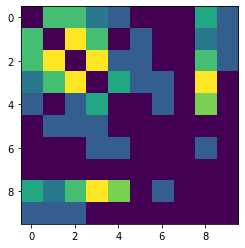

In [326]:
plt.imshow(K) # un-normalised transition matrix

In [18]:
# Check that the matrix K = I x C_bar x I.T is symmetric

def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

In [19]:
check_symmetric(K)

True

In [327]:
res_e = hg_pagerank_power(T_e, 0.85, 100) # calculate PageRank for uniform walker (gamma = -1)

In [328]:
res_e

array([0.14426037, 0.11614953, 0.14857462, 0.14761767, 0.14307385,
       0.04756435, 0.04637982, 0.01519629, 0.14386007, 0.04732343])

In [329]:
res_n = hg_pagerank_power(T_n, 0.85, 100) # calculate PageRank for structured walker (gamma = 1)

In [330]:
res_n

array([0.12159512, 0.13757147, 0.16972783, 0.16991434, 0.09686759,
       0.04605431, 0.04649961, 0.01519629, 0.15025647, 0.04631697])

In [331]:
np.corrcoef(res_e, res_n) # correlation between the two measures

array([[1.        , 0.92925985],
       [0.92925985, 1.        ]])

### Generalisation to larger random graphs

In [261]:
import time

def compute_pgrk_correlations(num_list, gamma_1, gamma_2, graph_sparsity):
    """
    Computes the correlation between two PageRank centralities with biases gamma_1 and gamma_2 resepectively
    on hypergraphs on sizes provided by num_list. Hypergraphs are generated by Erdos Renyi bipartite model.
    
    =======================================================================================================
    
    Parameters:
    
    num_list - list of sizes of hypergraphs you want to compare centrality measures on
             - eg. num_list = np.logspace(1, 3, 10).astype(int)
    gamma_1, gamma_2 - walker biases for the PageRanks
    graph_sparsity - probability of a connection in the bipartite E-R model.
    
    
    Returns:
    
    corr_hist - correlations of the PageRanks on random graphs of specified size.
    
    """
    
    
    corr_hist = []
    
    for N in num_list:

        # generate a random bipartite graph of N nodes and \sqrt(N) hyperedges
        
        G = nx.bipartite.random_graph(N, np.round(np.sqrt(N),0).astype(int), graph_sparsity)
         
        # compute required matrices
            
        I = nx.bipartite.biadjacency_matrix(G, row_order = range(N)).toarray()
        A = I @ I.T
        A = A - np.diag(np.diag(A))
        C = I.T @ I
        C_hat = np.diag(np.diag(C))

        # compute the asymptotic walk distributions

        ##################################################################################

        # construct transition matrix of random walker with bias gamma_1

        gamma = gamma_1


        K_e = np.zeros((len(A), len(A)))
        C_alt = np.diag(np.diag((C_hat - 1).astype(float)**gamma)) # \bar{C} in the report
        C_alt = np.nan_to_num(C_alt, nan = 0, posinf = 0)

        K_e = (I @ C_alt @ I.T).astype(float)
        K_e = K_e - np.diag(np.diag(K_e))


        T_e = np.zeros((len(A), len(A)))
        for i in range(len(A)):
            norm = np.sum(K_e[i])
            if norm == 0:
                pass
            else:
                T_e[i, :] = K_e[i] / norm

        ###################################################################################

        # construct transition matrix of random walker with bias gamma_2

        gamma = gamma_2

        K_n = np.zeros((len(A), len(A)))
        C_alt = np.diag(np.diag((C_hat - 1).astype(float)**gamma)) # \bar{C} in the report
        C_alt = np.nan_to_num(C_alt, nan = 0, posinf = 0)

        K_n = (I @ C_alt @ I.T).astype(float)
        K_n = K_n - np.diag(np.diag(K_n))


        T_n = np.zeros((len(A), len(A)))
        for i in range(len(A)):
            norm = np.sum(K_n[i])
            if norm == 0:
                pass
            else:
                T_n[i, :] = K_n[i] / norm
                
        ##################################################################################
        
                
        # calculate PageRank of walkers with specified biases.
        
        res_e = hg_pagerank_power(T_e, 0.85, 100)
        res_w = hg_pagerank_power(T_n, 0.85, 100)
                
        corr_hist.append(np.corrcoef(res_e, res_w)[0,1])
        
    return corr_hist

In [332]:
# computing correlation between PageRank and the CEC measure

def generate_er_hypergraph(N, a):
    """
    
    Generates a random hypergraph by creating a bipartite network sing the Erdo-Renyi model.
    
    ========================================================================================
    
    Parameters:
    
    N - size of the hypergraph (int)
    a - sparisty of bipartite network (prob of a connection)
    
    Returns:
    
    I - incidence matrix of the hypergraph
    
    """

    G = nx.bipartite.random_graph(N, np.round(np.sqrt(N),0).astype(int), a)
    I = nx.bipartite.biadjacency_matrix(G, row_order = range(N)).toarray()
    return I
    
    
def compute_cec_ranking_svd(A):
    """
    
    Computes the CEC centrality measure using the SVD decompostion.
    
    ===============================================================
    
    Parameters:
    
    A - hyperadjacency matrix of hypergraph
    
    Returns:
    
    c - the CEC centrality scores
    
    
    """
    
    
    # using best rank one approximation
    rank = 1

    # Perform SVD on im and obtain individual matrices
    P, D, Q = np.linalg.svd(A, full_matrices=True)
    
    return np.abs(P[:, :rank].T[0]) / np.abs(np.sum(P[:, :rank].T[0]))


def compute_cec_ranking_power(A, num_sims):
    """
    
    Computes the CEC centrality measure using the power method.
    Code for the power method was altered from:
    
    https://en.wikipedia.org/wiki/Power_iteration
    
    
    ============================================================
    
    Parameters:
    
    A - hyperadjacency matrix of hypergraph
    num_sims - number of multiplications in the power method
    
    Returns:
    
    c - the CEC centrality scores
    
    
    """
    
    b_k = np.random.rand(len(A))

    for _ in range(num_sims):
        # calculate the matrix-by-vector product Ab
        b_k1 = np.dot(A, b_k)

        # calculate the norm
        b_k1_norm = np.linalg.norm(b_k1,1) # 1-norm normalisation

        # re normalize the vector
        b_k = b_k1 / b_k1_norm

    return b_k


def find_pgrk(I, gamma, alpha = 0.85):
    
    """
    Computes the PageRank measure $PG_{(\gamma)}$ with bias gamma for a hypergraph with incidence matrix I
    and teleportation parameter alpha.
    
    =======================================================================================================
    
    Parameters:
    
    I - incidence matrix of hypergraph
    gamma - bias of walker, as discussed in report
    alpha - PageRank teleporation parameter (default = 0.85)
    
    Returns:
    res_pgrk - the PageRank measures for the nodes of the hypergraph
    
    """
    
    # compute the pagerank of the non-linear walker on hypergraph with incidence matrix I and bias parameter gamma
    
    # generate incidence matrix of hypergraph of N nodes, sqrt(N) hyperedges via E-R model
    
    # hyper-adjacency matrix
    A = I @ I.T
    # hyper-edges matrix
    C = I.T @ I
    
    # generate transition matrix for PageRank
    
    C_hat = np.diag(np.diag(C))

    K = np.zeros((len(A), len(A)))
    C_alt = np.diag(np.diag((C_hat - 1).astype(float)**gamma))
    C_alt = np.nan_to_num(C_alt, nan = 0, posinf = 0)

    K = (I @ C_alt @ I.T).astype(float)
    K = K - np.diag(np.diag(K)) # simple walk => remove diagonal entries


    T = np.zeros((len(A), len(A))) # normalising matrix I \bar{C} I to generate tranisiton matrix
    for i in range(len(A)):
        norm = np.sum(K[i])
        if norm ==0:
            pass
        else:
            T[i, :] = K[i] / norm
            
    res_pgrk = hg_pagerank_power(T, alpha, 1000) # compute pagerank using power method, use for large matrices T
    #res_pgrk = hg_pagerank_full_eig_decomp(T, alpha) # use eigendecomp when $\alpha = 1$ as more stable and for small graphs
    return res_pgrk 



def compute_centrality_measures(I, gamma, alpha):
    """
    
    Takes a graph with incidence matrix I and computes its CEC node ranking and
    the PageRank ranking with parameters gamma and alpha.
    
    ===========================================================================
    
    Parameters:
    
    I - incidence matrix of hypergraph
    gamma - walk bias for PageRank
    alpha - teleportation bias for PageRank
    
    Returns:
    
    cec - CEC node measure
    pgrk - PageRank node measure
    """
    
    A = I @ I.T
    cec = compute_cec_ranking_power(A, 100)
    pgrk = find_pgrk(I, gamma, alpha)
    return cec, pgrk



def compute_correlation_cec_pgrk(num_list, gamma, alpha, scale_factor):
    """
    
    Compute the correlation between CEC and specific PageRank node measures for
    random Erdos-Renyi hypergraphs.
    
    ============================================================================
    
    Parameters:
    
    num_list - list of sizes of graphs considered (int)
    gamma - walk bias for PageRank
    alpha - teletportation bias for PageRank
    scale_factor - sparsity of E-R model.
    
    Returns:
    
    corr_hist - the correlation between the measures for randm hypergraphs of
                specified size
    
    """
    
    corr_list = [0]*len(num_list)
    for idx in range(len(num_list)):
        #print(idx)
        N = num_list[idx]
        start = time.time()
        I = generate_er_hypergraph(N, scale_factor)
        #print(time.time() - start)
        start = time.time()
        cec, pgrk = compute_centrality_measures(I, gamma, alpha)
        #print(time.time() - start)
        corr_list[idx] = np.corrcoef(cec, pgrk)[0,1]
    return corr_list

## Computing Correlation between CEC and PageRank for graphs of different size and different bias parameters.

In [339]:
gamma_list = np.linspace(-15, 15, 20)
num_list = np.logspace(1.3, 3, 25).astype(int)


res_matrix = np.zeros((len(gamma_list), len(num_list))) # results matrix
for i in range(len(gamma_list)):
    for j in range(len(num_list)):
        res_matrix[i,j] = compute_correlation_cec_pgrk([num_list[j]], gamma_list[i], 0.85, 0.2)[0]

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:107: RuntimeWarning: divide by zero encountered in power
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:107: RuntimeWarning: invalid value encountered in power


Text(0.5, 1.0, 'Correlations: CEC score and PageRank')

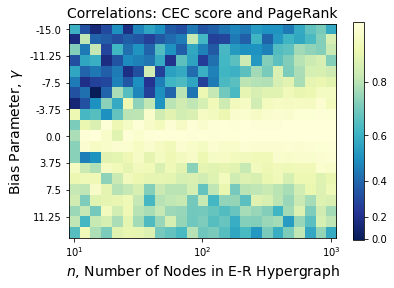

In [340]:
import matplotlib

plt.imshow(res_matrix, norm=matplotlib.colors.PowerNorm(1.5), cmap = "YlGnBu_r")
plt.colorbar()
plt.ylabel("Bias Parameter, $\gamma$", fontsize = 14)
plt.xlabel("$n$, Number of Nodes in E-R Hypergraph", fontsize = 14)


labels = [item.get_text() for item in ax.get_yticklabels()]
labels2 = [""] + list(np.linspace(-15, 15, 9))
ax = plt.gca()
ax.xaxis.set_ticks(np.arange(0, 25, 12))
ax.yaxis.set_ticklabels(labels2)

xticks = [ "$10^1$", "$10^2$", "$10^3$"]
ax.set_xticklabels(xticks)
plt.title("Correlations: CEC score and PageRank", fontsize = 14)
#plt.savefig("imgs/cec_pgrk_er_model_bias_and_num_nodes.pdf", bbox_inches = "tight")

## Scaling the bias parameter
$$
\Gamma(\gamma, N) = \gamma \log (N)
$$

In [343]:
gamma_list = np.linspace(-15, 15, 20)
num_list = np.logspace(1, 3, 25).astype(int)

def gamma_fn(gamma, N):
    return gamma*np.log(N)

res_matrix = np.zeros((len(gamma_list), len(num_list))) # results matrix
for i in range(len(gamma_list)):
    for j in range(len(num_list)):
        res_matrix[i,j] = compute_correlation_cec_pgrk([num_list[j]], gamma_fn(gamma_list[i], num_list[j]), 0.85, 0.2)[0]

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:107: RuntimeWarning: invalid value encountered in power


Text(0.5, 1.0, 'Correlations: CEC score and PageRank')

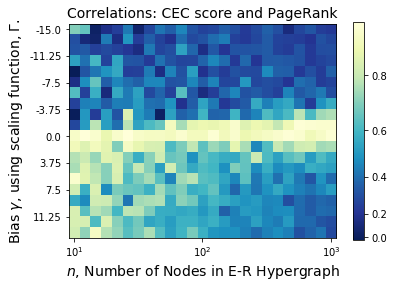

In [344]:
import matplotlib

plt.imshow(res_matrix, norm=matplotlib.colors.PowerNorm(1.5), cmap = "YlGnBu_r")
plt.colorbar()
plt.ylabel("Bias $\gamma$, using scaling function, $\Gamma$.", fontsize = 14)
plt.xlabel("$n$, Number of Nodes in E-R Hypergraph", fontsize = 14)


labels = [item.get_text() for item in ax.get_yticklabels()]
labels2 = [""] + list(np.linspace(-15, 15, 9))
ax = plt.gca()
ax.xaxis.set_ticks(np.arange(0, 25, 12))
ax.yaxis.set_ticklabels(labels2)

xticks = [ "$10^1$", "$10^2$", "$10^3$"]
ax.set_xticklabels(xticks)
plt.title("Correlations: CEC score and PageRank", fontsize = 14)
#plt.savefig("imgs/scaled_cec_pgrk_er_model_bias_and_num_nodes.pdf", bbox_inches = "tight")

In this figure, we have computed the correlation between the CEC and PageRank measures ($\alpha = 0.85$), varying both the bias parameter and the number of nodes.

## Computing correlations between PageRanks of two different biases.
$$
PG_{(\gamma_1)} \text{ compared to } PG_{(\gamma_2)} 
$$
Not used in the report

In [271]:
# find correlations of small graphs, average over many due to speed and flucations

num_list = np.logspace(1, 3, 22).astype(int)

avgs = [[] for _ in range(len(num_list))]

gamma_1 = -2 # specify the different gamma values for the PageRanks we want to compare
gamma_2 = 2

for i in range(300):
    corr_hist2 = compute_pgrk_correlations(num_list, gamma_1, gamma_2)
    for j in range(len(corr_hist2)):
        if np.isnan(corr_hist2[j]):
            pass # sometimes throws an error, passes in this case
        else:
            avgs[j].append(corr_hist2[j])
            
avgs_final = [np.mean(item) for item in avgs] # calculate the average

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in power


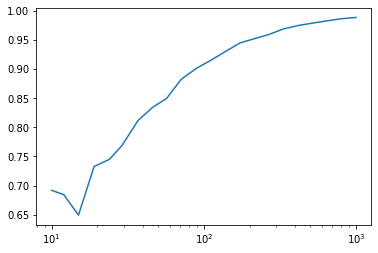

In [272]:
plt.semilogx(num_list, avgs_final)

In [273]:
# find correlations of larger graphs, only avg of 5 due to computational time required.

num_list = np.logspace(3.1, 4, 8).astype(int)

avgs2 = [[] for _ in range(len(num_list))]

for i in range(5):
    corr_hist2 = compute_pgrk_correlations(num_list, gamma_1, gamma_2)
    for j in range(len(corr_hist2)):
        if np.isnan(corr_hist2[j]):
            pass
        else:
            avgs2[j].append(corr_hist2[j])
            
avgs_final2 = [np.mean(item) for item in avgs2]

<module 'matplotlib.pyplot' from 'C:\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

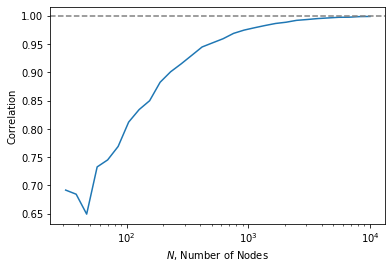

In [274]:
# append results together and plot

num_list = np.logspace(1.5, 4, 30)

plt.semilogx(num_list, avgs_final + avgs_final2)
plt.xlabel("$N$, Number of Nodes")
plt.ylabel("Correlation")
plt.axhline(1, linestyle = "--", color = "gray")
plt

In [144]:
er_walk_corr = avgs_final + avgs_final2

In [145]:
# import pickle

# with open('data/corr_r1_r_2_er_model.pkl', 'wb') as f: 
#     pickle.dump(er_walk_corr, f)